1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to find visually the regions.
* Use `scipy.optimize.minimize()`, optionally trying its optional arguments.

Only one global minum was found. Changing the initial guess does not modify the final result.
global minimum: x = [-0.0898, 0.7127], f(x0) = -1.0316


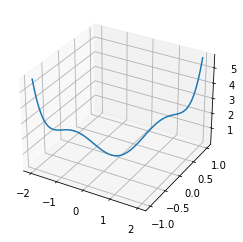

In [2]:
#Done but not following all the hints
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize, stats
import math
import scipy

def func(x): #defining the function
    return (4-2.1*x[0]**2+(x[0]**4)/3)*x[0]**2 +x[0]*x[1]+(4*x[1]**2 -4)*x[1]**2

x_interval = [-2,2] #restricting the regions given the hints
y_interval = [-1,1]

x =[]
x.append(np.linspace(x_interval[0],x_interval[1], 100))
x.append(np.linspace(y_interval[0],y_interval[1], 100))

ax = plt.axes(projection='3d')
ax.plot3D(x[0], x[1],func(x))

#sol = optimize.minimize_scalar(func, args = (5,))
#print(sol)
x0 = [0,0] #initial guess
res = optimize.basinhopping(func,x0)
#print(res)
print("Only one global minum was found. Changing the initial guess does not modify the final result.")
print("global minimum: x = [%.4f, %.4f], f(x0) = %.4f" % (res.x[0], res.x[1], res.fun))

2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  `17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18`

min: `-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58`

* Plot these temperatures.
* Find a suitable a function that can describe min and max temperatures. 
* Fit this function to the data with `scipy.optimize.curve_fit()`.
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

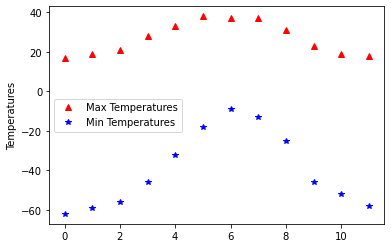

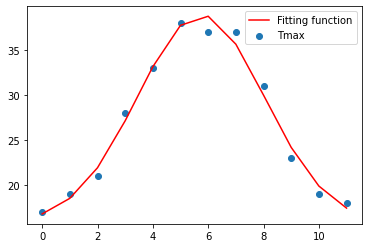

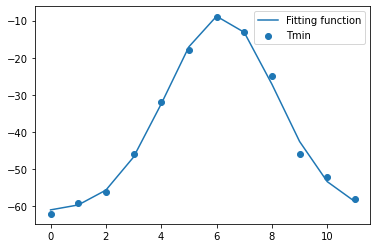

Both fitting are reasonable, though the fitting for the Tmin values required an initial guess to be correct.


In [4]:
#importing data
Tmax = [17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18]
Tmin = [-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58]
x = [i for i in range(len(Tmax))]

#setting the plot
plt.plot(x,Tmax, 'r^', label = 'Max Temperatures')
plt.plot(x,Tmin,'b*', label= 'Min Temperatures')
plt.ylabel("Temperatures")
plt.legend()
plt.show()

def gauss_function(x,a, x0, sigma,d): #chosen function to fit data
    return a*np.exp(-(x-x0)**2/(2*sigma**2)) + d

popt1,pcov1 = optimize.curve_fit(gauss_function, x, Tmax, full_output=False)
popt2,pcov2 = optimize.curve_fit(gauss_function, x, Tmin, p0 = [50, 6, 1, -60],full_output=False)

plt.plot(x, gauss_function(x, *popt1), 'r-', label = 'Fitting function')
plt.scatter(x, Tmax, label='Tmax')
plt.legend()
plt.show()

plt.plot(x, gauss_function(x, *popt2), label = 'Fitting function')
plt.scatter(x, Tmin, label='Tmin')
plt.legend()
plt.show()

print("Both fitting are reasonable, though the fitting for the Tmin values required an initial guess to be correct.")

3\. **Fit the residues**

Read the `data/residuals_261.pkl` file. If you haven't it already, download it from here:

```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```

The feature name "residual" contains the residuals (defined as $y_i - \hat{y}_i$) of a linear regression as a function of the independent variable "distances".

- Considering only the "residual" feature, create an histogram with the appropriate binning and display it.
- Set the appropriate Poisson uncertainty for each bin (thus, for each bin, $\sigma_i = \sqrt{n_i}$, where $n_i$ is the number of entries in each bin)
- By looking at the distribution of the residuals, define an appropriate function and fit it to the histogram of the residuals
- Perform a goodness-of-fit test. Is the p-value of the fit satisfactory?

chi2 = 5657.117942076039
p-value = 0.0


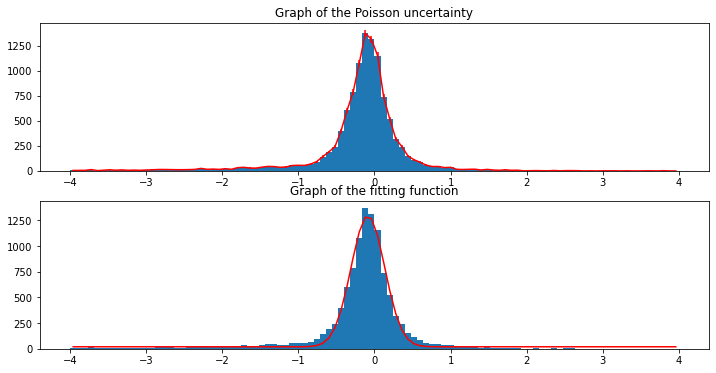

In [25]:
import pandas as pd
import scipy
from scipy import stats,optimize
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

###importing data from file

df = pd.read_pickle('data/residuals_261.pkl')
df = pd.DataFrame(df.item())
res = df['residuals'].to_numpy()
dist = df['distances'].to_numpy()

###plotting the data and determining the fitting function

fig,(ax1,ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (12,6))
b = 100 #setting the number of bins for the plot
h,bins,_ = ax1.hist(df['residuals'], bins = b, range = (-4,4))
bin_centres = (bins[:-1] + bins[1:])/2. #bin centres

sigma_y = np.sqrt(np.abs(h)) #poisson uncertainty
#print("standard deviation: ", sigma_y)

ax1.set_title("Graph of the Poisson uncertainty")
ax1.errorbar(x = bin_centres, y = h, yerr = sigma_y, color = 'red')
xmin,xmax = plt.xlim()

mu, std = stats.norm.fit(res) #getting mean and standard deviation
popt,pcov = optimize.curve_fit(gauss_function,bin_centres, h, p0 = [ max(res),mu,std,0]) #also setting starting point

ax2.set_title("Graph of the fitting function")
ax2.hist(res,bins = b, range = (-4,4))
ax2.plot(bin_centres, gauss_function(bin_centres, *popt), color ='red')

###goodness-of-fit test
opt_val = tuple(popt)
#print("values: ", opt_val)
g_fit = gauss_function(bin_centres, *popt)
ndof = len(bin_centres) - 1 #degrees of freedom
cov = np.cov(bin_centres, h, ddof=2)
b_hat = cov[0,1] / cov[0,0]
a_hat = np.mean(h - b_hat*bin_centres)
chi2 = np.sum(((h - g_fit)**2) / std**2)
print("chi2 =", chi2)
pvalue = 1. - stats.chi2.cdf(chi2, ndof)
print("p-value =", pvalue)

4\. **Temperatures in Munich**

Get the following data file:

```bash
https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
```

which gives the temperature in Munich every day for several years.


Fit the following function to the data:

$$f(t) = a \cos(2\pi t + b)+c$$

where $t$ is the time in years.

- Make a plot of the data and the best-fit model in the range 2008 to 2012.

   - What are the best-fit values of the parameters?

   - What is the overall average temperature in Munich, and what are the typical daily average values predicted by the model for the coldest and hottest time of year?

   - What is the meaning of the $b$ parameter, and what physical sense does it have?


- Now fit the data with the function $g(x)$, which has 1 more parameter than $f(x)$.
$$g(x) = a \cos(2\pi b t + c)+d$$
   - What are the RSS for $f(x)$ and $g(x)$?
   - Use the Fisher F-test to determine whether the additional parameter is motivated.

The mean temperature in Munich is  9.261252084167237
Average temperature in hottest days:  24.907408333333336
Average temperature in coldest days:  -9.777784


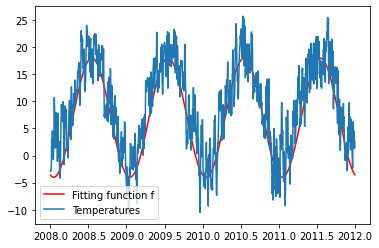

The parameter b is used as the phase of the cosine function, and it helps in correctly setting the starting point of the function according to the temperature values.


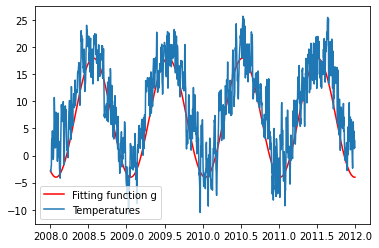

The SSR of the function f results  27090.211957471314
The SSR of the function g results  29893.488872361908
CL: 1.000 , additional parameter necessary: NO


In [38]:
#!wget https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt --no-check-certificate
#!type munich_temperatures_average_with_bad_data.txt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

def f(t,a,b,c): #function definition
    return a * math.cos(2*np.pi*t + b) + c

###importing data using pandas
data = pd.read_csv('munich_temperatures_average_with_bad_data.txt', sep=" ", header=None)
data.columns = ["Year", "Temperature"]

dataf = data[(data['Year'] > 2008) & (data['Year'] < 2012)].reset_index() #extracting desired columns in new dataframe
dataf = dataf.drop(dataf[dataf['Temperature'] == 99.].index).reset_index() #clearing data from bad samples

x = dataf['Year'].to_numpy()
a,b,c = -11,6,7 #setting the parameters for the function

temp = dataf['Temperature'].to_numpy()
mean_T = np.mean(temp)
y1 = [f(x[i],a,b,c) for i in range(len(x))]
print("The mean temperature in Munich is ",mean_T)

av1 = dataf.nlargest(12, 'Temperature') #getting the 10 hottest days (why two days at 99 degrees? Gonna delete them)
av1 = av1[av1['Temperature'] != 99.] #top 10 hottest days without weird numbers
av_hot = np.mean(av1['Temperature'].to_numpy())
print("Average temperature in hottest days: ", av_hot)

av2 = dataf.nsmallest(10, 'Temperature')
av_cold = np.mean(av2['Temperature'].to_numpy())
print("Average temperature in coldest days: ", av_cold)

###plotting data
plt.plot(x, y1,'r-', label = "Fitting function f")
plt.plot(x, dataf['Temperature'], label = "Temperatures")
plt.legend()
plt.show()

print("The parameter b is used as the phase of the cosine function, and it helps in correctly setting the starting point of the function according to the temperature values.")

def g(t,a,b,c,d):
    return a * math.cos(2*np.pi*b*t + c) + d

a,b,c,d = -11,1.02,4.8,7
y2 = [g(x[i],a,b,c,d) for i in range(len(x))]
plt.plot(x, y2,'r-', label = "Fitting function g")
plt.plot(x, dataf['Temperature'], label = "Temperatures")
plt.legend()
plt.show()

###RSS of the functions
fSSR = 0
gSSR = 0

for i in range(len(x)-1):
    fSSR = fSSR + (temp[i] - y1[i])**2
    gSSR = gSSR + (temp[i] - y2[i])**2

print("The SSR of the function f results ", fSSR)
print("The SSR of the function g results ", gSSR)

#Fisher f-test

from scipy.stats import f

### Using the define function presented in lecture 08
def Ftest(ssr_1, ssr_2, ndof_1, ndof_2, nbins, verbose=True):
    F = ((ssr_1 - ssr_2)/(ndof_2 - ndof_1)) / (ssr_2/(nbins - ndof_2))
    CL = 1. - f.cdf(F, ndof_2 - ndof_1, nbins - ndof_2)
    if verbose: print("CL: %.3f" % CL, ", additional parameter necessary:", "YES" if CL < 0.10 else "NO")
    return CL

f_vs_g = Ftest(fSSR, gSSR, 3,4, len(x))